In [1]:
# ============================================
# OLIVE PROCESS-BASED MODEL (ENGLISH VERSION)
# Reference: Moriondo et al. (2019) / Villalobos et al. (2013)
# Configuration: Super-Intensive Arbequina (Chile)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


columns = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

Omega = np.load("../genai/scenarios.npy")
df = pd.DataFrame(Omega[0], columns=columns)


print(df.columns)
fixed_window = pd.read_csv('../genai/fixed_window.csv', index_col=0)
print(fixed_window.columns)
fixed_window.columns = columns
print(fixed_window.columns)
df = pd.concat([fixed_window, df])
print(df.columns)
try:
    
    #df['T2M'] = (df["T2M_MIN"] + df["T2M_MAX"])/2 
    print(df.columns)
    #df.rename(columns={"ALLSKY_SFC_SW_DWN":"RS", "CLRSKY_SFC_SW_DWN": "RSO",
    #            "PRECTOTCORR": "PRECIPITATION"}, inplace=True)
    # CLRSKY_SFC_SW_DWN?
    #df['RSO'] = df['RS']
    #print(df.columns)
    # Merge with real data and fix scenario generation according tactical planning  
    df_season = df#.loc['2022-11-01':'2023-04-29'].copy()
    if len(df_season) < 180:
        print(f"Warning: Season data is short ({len(df_season)} days). Using available data.")
    else:
        df_season = df_season.iloc[:180]
    print(f"Loaded {len(df_season)} days of weather data for simulation.")
except FileNotFoundError:
    print("="*50)
    print("ERROR: Data file not found. Please re-run Cell 4 to download the data.")
    print("="*50)

Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Loaded 180 days of weather data for simulation.


In [2]:
df_season.reset_index(inplace=True)


# 2025-12-02 Crop model

In [3]:
print(df)

from datetime import date, timedelta

start_date = date(2024, 8, 30)
# Create a list of 180 days, starting from the day after start_date
date_list = [start_date + timedelta(days=x) for x in range(1, 181)]

df['DATE'] = date_list

df.DATE = pd.to_datetime(df.DATE)
df.set_index('DATE', inplace=True)

     T2M_MIN    T2M_MAX  PRECTOTCORR  ALLSKY_SFC_SW_DWN       RH2M      WS2M
0   6.830000  18.260000     0.000000           6.540000  82.480000  1.130000
1   6.200000  15.340000     0.000000           6.370000  84.810000  1.240000
2   4.590000  16.790000     0.000000          15.850000  74.550000  2.050000
3   0.970000  23.150000     0.000000          18.940000  63.160000  1.980000
4   4.630000  21.940000     0.000000          19.380000  66.540000  1.190000
..       ...        ...          ...                ...        ...       ...
55  8.750850  13.817754     2.698063           7.132063  77.296646  1.693531
56  5.466936  18.642084     0.740222          23.911379  72.229591  1.372966
57  4.688178  20.801809     0.128090          29.092003  70.570923  1.582005
58  6.155434  23.774721    -0.291742          26.166977  66.427025  1.409660
59  8.226084  26.256895    -0.175512          25.574631  67.752052  1.665095

[180 rows x 6 columns]


In [4]:

# ==========================================================
# 0. CALIBRATION GUIDE (READ FIRST)
# ==========================================================
print("="*60)
print("      >>> MODEL CALIBRATION GUIDE: PARAMETERS TO TUNE <<<")
print("="*60)
print("To adapt this model to a REAL site, modify these keys in 'params':")
print("1. PHENOLOGY:")
print("   - 'Ccrit': Critical Chilling Units. Lower it if trees bloom too late.")
print("   - 'FcritFlo': Thermal forcing units. Adjusts flowering date.")
print("2. SOIL & WATER:")
print("   - 'TTSW1'/'TTSW2': Soil water holding capacity (Texture/Depth).")
print("   - 'Irrigation_Threshold': 0.85 = No Stress, 0.50 = Deficit Irrigation.")
print("3. ARCHITECTURE:")
print("   - 'PlantD': Planting Density (Trees/ha).")
print("   - 'LAD': Leaf Area Density. High density = more shading.")
print("="*60 + "\n")


# ==========================================================
# 1. SETUP AND DATA LOADING (Chile-aware + One-Season Ready)
# ==========================================================

# ==========================================================
# 2. PARAMETERIZATION (Mapped to Sources)
# ==========================================================
params = dict(
    # --- ARCHITECTURE (Arbequina Super-Intensive) ---
    PlantD = 1600.0,      # [Trees/ha] Density 1.5x4m. (Source: Farm Management)
    PlantA = 10000/1600,  # [m2] Area per tree.
    LAD    = 2.0,         # [m2/m3] Leaf Area Density. (Source: Villalobos et al., 2013)

    # --- PHENOLOGY (De Melo-Abreu et al. 2004) ---
    # Chill: Triangular function parameters
    T_opt_chill = 7.2,    # [°C] Optimal Chilling Temp.
    T_max_chill = 16.0,   # [°C] Max Effective Temp.
    Ccrit       = 350.0,  # [Chill Units] Dormancy Break Threshold. (Source: De Melo-Abreu)

    # Forcing: Heat accumulation
    Tb_forcing  = 9.0,    # [°C] Base Temp. (Source: Alcalá & Barranco 1992)
    FcritFlo    = 450.0,  # [GDD] Growing Degree Days to Flower. (Source: Moriondo)

    # --- PHOTOSYNTHESIS & GROWTH ---
    RUE_ol = 1.35,        # [g DM/MJ] Radiation Use Efficiency. (Source: Villalobos et al. 2006)
    SLA_ol = 5.2,         # [m2/kg] Specific Leaf Area. (Source: Mariscal et al. 2000)

    # Partitioning
    Part_Leaf  = 0.18,    # [-] Fraction to Leaves. (Source: Moriondo Eq. 8)
    Part_Fruit = 0.50,    # [-] Fraction to Fruit. (Source: High Yield Calibration)

    # --- SOIL (Site Specific) ---
    TTSW1 = 70.0,         # [mm] Topsoil Capacity.
    TTSW2 = 110.0,        # [mm] Subsoil Capacity.
    Initial_Saturation = 0.90, # [-] Initial Water Status (Post-Irrigation)

    # --- STRESS & RESPONSE (Moriondo Eq. 22) ---
    Stress_a = 5.0,       # [-] Sigmoid param a.
    Stress_b = 4.0,       # [-] Sigmoid param b.
    TE_coeff = 4.0,       # [Pa] Transpiration Efficiency Coeff. (Source: Moriondo Table 2)

    # --- IRRIGATION MANAGEMENT ---
    # Strategy: "Controlled Deficit". Irrigate when FTSW < 20%
    Irrigation_Threshold = 0.20,
    Irrigation_Efficiency = 0.95,

    # --- STRUCTURAL COEFFICIENTS (Moriondo Table 2) ---
    Ck1=0.52, Ck2=0.000788, Ck3=0.76, Ck4=1.25
)

# Consistent Initialization (Adult Orchard)
params['LAI_ini'] = 3.5
params['Vol_ini'] = (params['LAI_ini'] * params['PlantA']) / params['LAD']

# ==========================================================
# 3. FUNCTIONS (Equation Mapping)
# ==========================================================

def calc_chill_triangular(Tmean, Topt, Tmax):
    """ [Phenology] Triangular Model (De Melo-Abreu et al.) """
    if Tmean <= 0 or Tmean >= Tmax: return 0.0
    return Tmean/Topt if Tmean <= Topt else (Tmax-Tmean)/(Tmax-Topt)

def calc_eq6_k_prime(PlantD, LAD, p):
    """ [Eq. 6] Extinction Coefficient for discontinuous canopies """
    return p['Ck1'] + p['Ck2']*PlantD - p['Ck3']*np.exp(-p['Ck4']*LAD)

def calc_eq5_Int_OT(k_prime, Vol, PlantA):
    """ [Eq. 5] Intercepted Radiation (Modified Beer's Law) """
    v_per_m2 = Vol / PlantA
    return 1.0 - np.exp(-k_prime * v_per_m2)

def calc_eq22_RelTr(FTSW, a, b):
    """ [Eq. 22] Relative Transpiration (Stress Factor 0-1) """
    return 1.0 / (1.0 + a * np.exp(-b * FTSW))

# ==========================================================
# 4. PRE-PROCESSING
# ==========================================================
df["TAVG"] = (df["T2M_MAX"] + df["T2M_MIN"]) / 2.0
# Radiation conversion: Ensure MJ/m2
rad_factor = 1.0 if df["ALLSKY_SFC_SW_DWN"].mean() < 40 else 0.0036
df["PAR_MJ"] = df["ALLSKY_SFC_SW_DWN"] * rad_factor * 0.48
# VPD Calculation (Tetens)
es = 0.6108 * np.exp(17.27 * df["TAVG"] / (df["TAVG"] + 237.3))
ea = es * (df["RH2M"] / 100.0)
df["VPD_kPa"] = np.maximum(0.1, es - ea) # Used in [Eq. 16]
df["RAIN_mm"] = df["PRECTOTCORR"]        # Used in [Eq. 18]

# ==========================================================
# 5. SIMULATION LOOP (PIPELINE)
# ==========================================================
# Initial State
LAI_sim = params['LAI_ini']
Vol_sim = params['Vol_ini']
ATSW1 = params['TTSW1'] * params['Initial_Saturation']
ATSW2 = params['TTSW2'] * params['Initial_Saturation']

# Accumulators
chill_cum = 0; forcing_cum = 0
dormancy_released = False; anthesis_occurred = False; anthesis_date = None
bio_fruit_cum = 0
irrigation_annual_mm = 0

results = []



      >>> MODEL CALIBRATION GUIDE: PARAMETERS TO TUNE <<<
To adapt this model to a REAL site, modify these keys in 'params':
1. PHENOLOGY:
   - 'Ccrit': Critical Chilling Units. Lower it if trees bloom too late.
   - 'FcritFlo': Thermal forcing units. Adjusts flowering date.
2. SOIL & WATER:
   - 'TTSW1'/'TTSW2': Soil water holding capacity (Texture/Depth).
   - 'Irrigation_Threshold': 0.85 = No Stress, 0.50 = Deficit Irrigation.
3. ARCHITECTURE:
   - 'PlantD': Planting Density (Trees/ha).
   - 'LAD': Leaf Area Density. High density = more shading.



Strategy: Irrigation Threshold 20.0%
[ALERT] 2024-11-02 HEAT SHOCK! Damage: 29%
[ALERT] 2024-11-23 HEAT SHOCK! Damage: 15%
[ALERT] 2024-11-26 HEAT SHOCK! Damage: 26%
[ALERT] 2024-11-27 HEAT SHOCK! Damage: 85%
[ALERT] 2024-11-28 HEAT SHOCK! Damage: 64%
  [JAN] 2025 | FTSW: 0.69 | Stomata: 0.76 | Yield: 1454 g/m2

FINAL AUDIT (Irrigation Threshold: 20.0%)
Average Yield:      nan kg/ha (Fresh Olive)
Average Irrigation: nan mm/year
------------------------------------------------------------
❌ FAILURE: Review Chilling or Stress parameters.


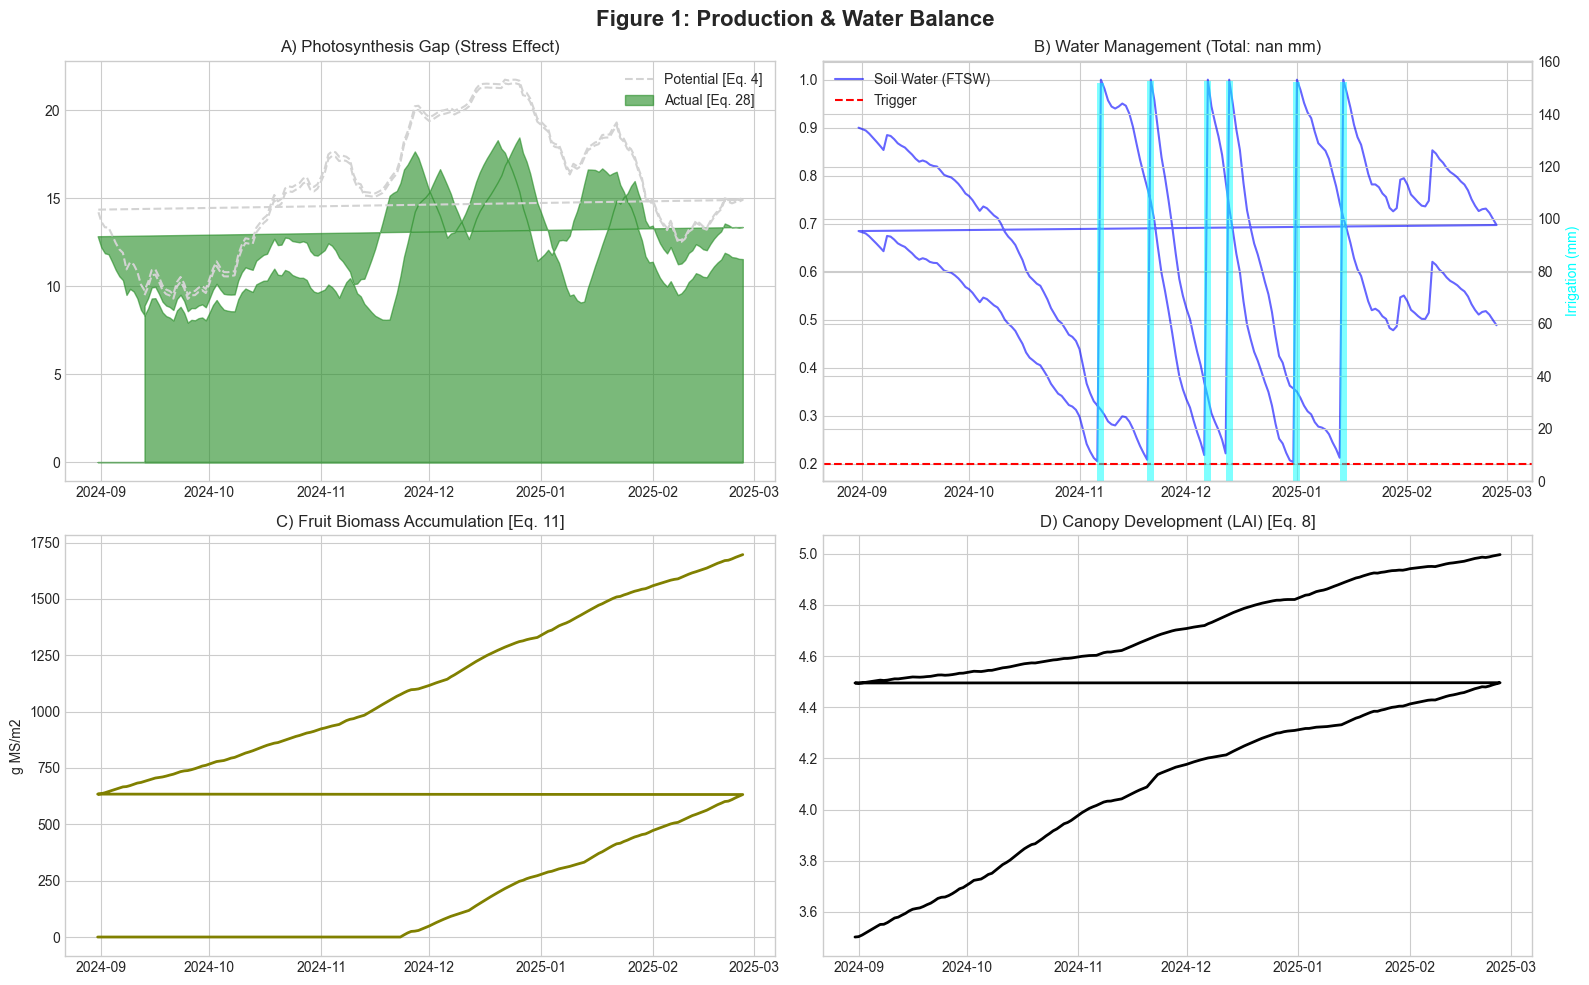

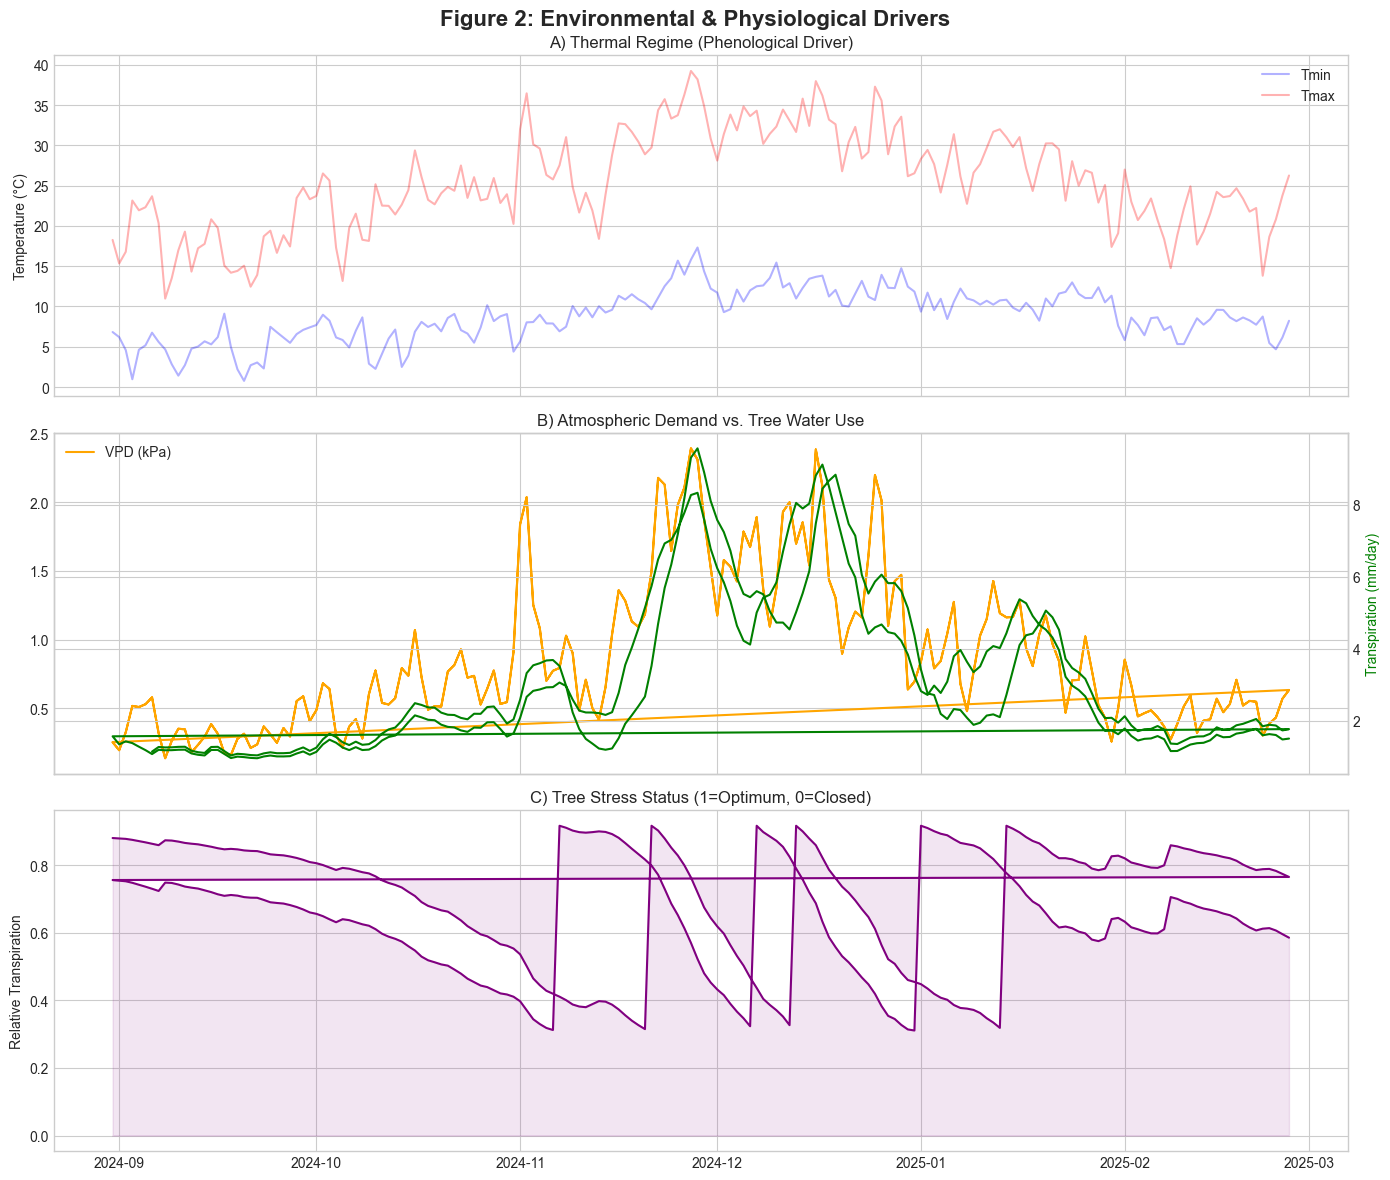


[Image of Soil Plant Atmosphere Continuum diagram]


In [6]:
print(f"Strategy: Irrigation Threshold {params['Irrigation_Threshold']*100}%")

VERBOSE = True

for date, row in df.iterrows():

    # ANNUAL RESET (July 1st - Southern Hemisphere Winter)
    if date.month == 7 and date.day == 1:
        if VERBOSE and date.year > df.index[0].year:
             print(f"\n--- SEASON {date.year}-{date.year+1} | Total Irrigation: {irrigation_annual_mm:.0f} mm ---")
        chill_cum = 0; forcing_cum = 0
        dormancy_released = False; anthesis_occurred = False; anthesis_date = None
        bio_fruit_cum = 0; irrigation_annual_mm = 0

    # --- PHENOLOGY ---
    if not dormancy_released:
        # Chill accumulation (Triangular * 24 hours)
        chill_efficiency = calc_chill_triangular(row["TAVG"], params['T_opt_chill'], params['T_max_chill'])
        chill_cum += chill_efficiency * 24.0

        if chill_cum >= params['Ccrit']:
            dormancy_released = True
            if VERBOSE: print(f"[PHENO] {date.date()} ❄️ Dormancy Released (Chill: {chill_cum:.0f})")
    elif not anthesis_occurred:
        # Heat accumulation (Linear)
        forcing_cum += max(0.0, row["TAVG"] - params['Tb_forcing'])
        if forcing_cum >= params['FcritFlo']:
            anthesis_occurred = True
            anthesis_date = date
            if VERBOSE: print(f"[PHENO] {date.date()} 🌸 ANTHESIS (Flowering)")

    # --- LIGHT INTERCEPTION [Eq. 5-6] ---
    k_prime = calc_eq6_k_prime(params['PlantD'], params['LAD'], params)
    Int_OT  = calc_eq5_Int_OT(k_prime, Vol_sim, params['PlantA'])

    # --- POTENTIAL PRODUCTION [Eq. 4] ---
    DM_pot  = Int_OT * row["PAR_MJ"] * params['RUE_ol']

    # --- IRRIGATION LOGIC ---
    total_capacity = params['TTSW1'] + params['TTSW2']
    current_water = ATSW1 + ATSW2
    current_FTSW = current_water / total_capacity
    irrigation_today = 0.0

    # Trigger: If FTSW < Threshold during active season
    if current_FTSW < params['Irrigation_Threshold'] and date.month in [9,10,11,12,1,2,3,4]:
        deficit = total_capacity - current_water
        irrigation_today = deficit / params['Irrigation_Efficiency']
        irrigation_annual_mm += irrigation_today
        ATSW1 += irrigation_today

    # --- WATER BALANCE [Eq. 18-19] ---
    ATSW1 += row["RAIN_mm"]
    if ATSW1 > params['TTSW1']: # Overflow Layer 1 -> 2
        excess = ATSW1 - params['TTSW1']
        ATSW1 = params['TTSW1']
        ATSW2 += excess
    if ATSW2 > params['TTSW2']: ATSW2 = params['TTSW2'] # Deep drainage

    # [Eq. 21] System Water Status
    FTSW = (ATSW1 + ATSW2) / total_capacity

    # --- STRESS FACTORS [Eq. 22] ---
    RelTr = calc_eq22_RelTr(FTSW, params['Stress_a'], params['Stress_b'])

    # [Eq. 27] Efficiency Adjustment (Stomatal Closure increases WUE)
    RelTE = -0.6 * RelTr + 1.6

    # [Eq. 28] Actual Biomass
    DM_act = DM_pot * RelTr * RelTE

    # --- GROWTH & PARTITIONING [Eq. 8-11] ---
    growth_leaf = 0; growth_fruit = 0
    if anthesis_occurred:
        # [Eq. 35] Heat Shock Logic
        HI_shock = 1.0
        if (date - anthesis_date).days < 10 and row["T2M_MAX"] > 35:
             HI_shock = max(0, 1 - (row["T2M_MAX"]-35)/5.0)
             if VERBOSE: print(f"[ALERT] {date.date()} HEAT SHOCK! Damage: {(1-HI_shock)*100:.0f}%")

        growth_fruit = DM_act * params['Part_Fruit'] * HI_shock
        growth_leaf  = DM_act * (1 - params['Part_Fruit']) * params['Part_Leaf']
    else:
        growth_leaf  = DM_act * 1.0 * params['Part_Leaf']

    bio_fruit_cum += growth_fruit

    # Update Structure
    d_LAI = (growth_leaf * params['SLA_ol']) / 1000.0
    LAI_sen = LAI_sim * 0.0006
    LAI_sim = LAI_sim + d_LAI - LAI_sen
    Vol_sim = (LAI_sim * params['PlantA']) / params['LAD']

    # --- WATER CONSUMPTION [Eq. 15-16] ---
    VPD_eff = min(row["VPD_kPa"], 4.5)
    TE = params['TE_coeff'] / max(0.5, VPD_eff)
    Tr_act = (DM_act / TE) if TE > 0 else 0
    Evap = 1.2 * (1 - Int_OT) * (ATSW1/params['TTSW1']) # Soil Evaporation

    water_loss = Tr_act + Evap
    if water_loss > ATSW1:
        rem = water_loss - ATSW1
        ATSW1 = 0
        ATSW2 = max(0, ATSW2 - rem)
    else:
        ATSW1 -= water_loss

    # Spot Check (January)
    if date.day == 15 and date.month == 1 and VERBOSE:
        print(f"  [JAN] {date.year} | FTSW: {FTSW:.2f} | Stomata: {RelTr:.2f} | Yield: {bio_fruit_cum:.0f} g/m2")

    results.append({
        "DATE": date, "Yield_g": bio_fruit_cum, "FTSW": FTSW,
        "RelTr": RelTr, "Irrigation": irrigation_today, "Tr_mm": Tr_act,
        "DM_pot": DM_pot, "DM_act": DM_act, "LAI": LAI_sim, "VPD": row["VPD_kPa"]
    })

# ==========================================================
# 6. RESULTS & AUDIT
# ==========================================================
res_df = pd.DataFrame(results).set_index("DATE")
final_yields = res_df.groupby(res_df.index.year)["Yield_g"].max()
valid_yields = final_yields.iloc[1:-1]
avg_yield_kg_ha = valid_yields.mean() * 10 * 2.2
avg_irrig = res_df.groupby(res_df.index.year)["Irrigation"].sum().iloc[1:-1].mean()

print("\n" + "="*60)
print(f"FINAL AUDIT (Irrigation Threshold: {params['Irrigation_Threshold']*100}%)")
print("="*60)
print(f"Average Yield:      {avg_yield_kg_ha:.0f} kg/ha (Fresh Olive)")
print(f"Average Irrigation: {avg_irrig:.0f} mm/year")
print("-" * 60)

if avg_yield_kg_ha > 12000:
    print("✅ SUCCESS: Commercial Super-Intensive Yield Achieved.")
elif avg_yield_kg_ha > 5000:
    print("⚠️ MODERATE: Typical of low-input management.")
else:
    print("❌ FAILURE: Review Chilling or Stress parameters.")

# ==========================================================
# 7. VISUALIZATION (FIGURES)
# ==========================================================
plt.style.use('seaborn-v0_8-whitegrid')

# --- FIGURE 1: PRODUCTION & WATER MANAGEMENT ---
fig1, axes = plt.subplots(2, 2, figsize=(16, 10))
fig1.suptitle(f'Figure 1: Production & Water Balance', fontsize=16, fontweight='bold')

# A) Biomass Gap
ax1 = axes[0, 0]
ax1.plot(res_df.index, res_df["DM_pot"].rolling(14).mean(), color='lightgray', ls='--', label='Potential [Eq. 4]')
ax1.fill_between(res_df.index, res_df["DM_act"].rolling(14).mean(), color='forestgreen', alpha=0.6, label='Actual [Eq. 28]')
ax1.set_title("A) Photosynthesis Gap (Stress Effect)", fontsize=12)
ax1.legend()

# B) Irrigation & Soil Water
ax2 = axes[0, 1]
ax2.plot(res_df.index, res_df["FTSW"], color='blue', alpha=0.6, label='Soil Water (FTSW)')
ax2.axhline(params['Irrigation_Threshold'], color='red', ls='--', label='Trigger')
ax2_bis = ax2.twinx()
ax2_bis.bar(res_df.index, res_df["Irrigation"], color='cyan', alpha=0.5, width=2, label='Irrigation (mm)')
ax2_bis.set_ylabel('Irrigation (mm)', color='cyan')
ax2.set_title(f"B) Water Management (Total: {avg_irrig:.0f} mm)", fontsize=12)
ax2.legend(loc='upper left')

# C) Yield Accumulation
ax3 = axes[1, 0]
ax3.plot(res_df.index, res_df["Yield_g"], color='olive', lw=2)
ax3.set_title("C) Fruit Biomass Accumulation [Eq. 11]", fontsize=12)
ax3.set_ylabel("g MS/m2")

# D) Canopy Structure
ax4 = axes[1, 1]
ax4.plot(res_df.index, res_df["LAI"], color='black', lw=2)
ax4.set_title("D) Canopy Development (LAI) [Eq. 8]", fontsize=12)

plt.tight_layout()
plt.show()

# --- FIGURE 2: ENVIRONMENTAL DRIVERS (NEW!) ---
fig2, axes2 = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig2.suptitle(f'Figure 2: Environmental & Physiological Drivers', fontsize=16, fontweight='bold')

# A) Temperature & Phenology
ax_temp = axes2[0]
ax_temp.plot(df.index, df["T2M_MIN"], color='blue', alpha=0.3, label='Tmin')
ax_temp.plot(df.index, df["T2M_MAX"], color='red', alpha=0.3, label='Tmax')
ax_temp.set_ylabel("Temperature (°C)")
ax_temp.legend(loc='upper right')
ax_temp.set_title("A) Thermal Regime (Phenological Driver)", fontsize=12)

# B) Atmospheric Demand (VPD) vs Transpiration
ax_vpd = axes2[1]
ax_vpd.plot(res_df.index, res_df["VPD"], color='orange', label='VPD (kPa)')
ax_vpd_bis = ax_vpd.twinx()
ax_vpd_bis.plot(res_df.index, res_df["Tr_mm"].rolling(7).mean(), color='green', lw=1.5, label='Transpiration (mm/d)')
ax_vpd_bis.set_ylabel("Transpiration (mm/day)", color='green')
ax_vpd.legend(loc='upper left')
ax_vpd.set_title("B) Atmospheric Demand vs. Tree Water Use", fontsize=12)

# C) Physiological Status
ax_phys = axes2[2]
ax_phys.plot(res_df.index, res_df["RelTr"], color='purple', lw=1.5, label='Stomatal Conductance (0-1)')
ax_phys.fill_between(res_df.index, res_df["RelTr"], 0, color='purple', alpha=0.1)
ax_phys.set_ylabel("Relative Transpiration")
ax_phys.set_title("C) Tree Stress Status (1=Optimum, 0=Closed)", fontsize=12)

plt.tight_layout()
plt.show()

print("\n[Image of Soil Plant Atmosphere Continuum diagram]")